In [ ]:
!pip install Keras
!pip install Pillow
!pip install tensorflow
!pip install pillow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img
from math import isnan
from PIL import UnidentifiedImageError

SIZE=(160,160,3)
ALPHA=0.3

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=8, zoom_range=0.1, fill_mode='nearest', channel_shift_range=0.1)

def apply_transform(images, datagen):
    for x in datagen.flow(images, batch_size=len(images), shuffle=False):
        return x


def define_triplets_batch(filenames,labels,nbof_triplet = 21 * 3):
    triplet_train = []
    y_triplet = np.empty(nbof_triplet)
    classes = np.unique(labels)
    for i in range(0,nbof_triplet,3):
        # Pick a class and chose two pictures from this class
        classAP = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classAP)
        keep_classAP = filenames[keep]
        keep_classAP_idx = labels[keep]
        idx_image1 = np.random.randint(len(keep_classAP))
        idx_image2 = np.random.randint(len(keep_classAP))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(keep_classAP))

        triplet_train += [keep_classAP[idx_image1]]
        triplet_train += [keep_classAP[idx_image2]]
        y_triplet[i] = keep_classAP_idx[idx_image1]
        y_triplet[i+1] = keep_classAP_idx[idx_image2]
        # Pick a class for the negative picture
        classN = classes[np.random.randint(len(classes))]
        while classN==classAP:
            classN = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classN)
        keep_classN = filenames[keep]
        keep_classN_idx = labels[keep]
        idx_image3 = np.random.randint(len(keep_classN))
        triplet_train += [keep_classN[idx_image3]]
        y_triplet[i+2] = keep_classN_idx[idx_image3]
        
    return triplet_train, y_triplet
    

def define_adaptive_hard_triplets_batch(filenames, labels, predict, nbof_triplet=21*3, use_neg=True, use_pos=True):
    # Check if we have the right number of triplets
    assert nbof_triplet%3 == 0
    
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    
    triplets = []
    y_triplets = np.empty(nbof_triplet)
    pred_triplets = np.empty((nbof_triplet,predict.shape[-1]))
    
    for i in range(0,nbof_triplet,3):
        # Chooses the first class randomly
        keep = np.equal(labels,classes[np.random.randint(len(classes))])
        keep_filenames = filenames[keep]
        keep_labels = labels[keep]
        
        # Chooses the first image among this class randomly
        idx_image1 = np.random.randint(len(keep_labels))
        
        # Computes the distance between the chosen image and the rest of the class
        
        if use_pos:
            # pick hard triplet: dst(anchor, negative) < dst(anchor, positive)
            dist_class = np.sum(np.square(predict[keep]-predict[keep][idx_image1]),axis=-1)
            idx_image2 = np.argmax(dist_class)
        else:
            # pick soft triplet (just a random positive)
            idx_image2 = np.random.randint(len(keep_labels))
            j = 0
            while idx_image1==idx_image2:
                idx_image2 = np.random.randint(len(keep_labels))
                # Just to prevent endless loop:
                j += 1
                if j == 1000:
                    print("[Error: define_hard_triplets_batch] Endless loop.")
                    break
        triplets += [keep_filenames[idx_image1]]
        y_triplets[i] = keep_labels[idx_image1]
        pred_triplets[i] = predict[keep][idx_image1]
        triplets += [keep_filenames[idx_image2]]
        y_triplets[i+1] = keep_labels[idx_image2]
        pred_triplets[i+1] = predict[keep][idx_image2]
        
        # Computes the distance between the chosen image and the rest of the other classes
        not_keep = np.logical_not(keep)
      
        if use_neg:
            dist_other = np.sum(np.square(predict[not_keep]-predict[keep][idx_image1]),axis=-1)
            idx_image3 = np.argmin(dist_other) 
        else:
            idx_image3 = np.random.randint(len(filenames[not_keep]))
            
        triplets += [filenames[not_keep][idx_image3]]
        y_triplets[i+2] = labels[not_keep][idx_image3]
        pred_triplets[i+2] = predict[not_keep][idx_image3]
        
    return np.array(triplets), y_triplets, pred_triplets

def load_images(filenames):
    h,w,c=SIZE
    images=np.empty((len(filenames),h,w,c))
    for i,f in enumerate(filenames):
      try:
          images[i]=np.array(load_img(f, target_size=SIZE))/255.0
      except UnidentifiedImageError as e:
          print("Error processing image {}".format(f))
          print(str(e))
      #images[i]=skimage.io.imread(f)/255.0
    return images


def image_generator(filenames, labels, batch_size=63, use_aug=True, datagen=datagen):
    while True:
        f_triplet, y_triplet = define_triplets_batch(filenames, labels, batch_size)
        i_triplet = load_images(f_triplet)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
        yield (i_triplet, y_triplet)

def predict_generator(filenames, batch_size=32):
    for i in range(0,len(filenames),batch_size):
        images_batch = load_images(filenames[i:i+batch_size])
        yield images_batch

def online_adaptive_hard_image_generator(filenames, labels, model, loss, batch_size=63, nbof_subclasses=10, use_aug=True,datagen=datagen):
    hard_triplet_ratio = 0
    nbof_hard_triplets = 0
    while True:
        # Select a certain amount of subclasses
        classes = np.unique(labels)
        subclasses = np.random.choice(classes,size=nbof_subclasses,replace=False)
        
        keep_classes = np.equal(labels,subclasses[0])
        for i in range(1, len(subclasses)):
            keep_classes = np.logical_or(keep_classes,np.equal(labels,subclasses[i]))
        subfilenames = filenames[keep_classes]
        sublabels = labels[keep_classes]
        predict = model.predict(predict_generator(subfilenames, 32), steps=int(np.ceil(len(subfilenames)/32)))
        
        # TEST: removing this for testing purposes
        # f_triplet_hard, y_triplet_hard, predict_hard = define_adaptive_hard_triplets_batch(subfilenames, sublabels, predict, nbof_hard_triplets*3, use_neg=True, use_pos=True)
        
        f_triplet_hard, y_triplet_hard, predict_hard = define_adaptive_hard_triplets_batch(subfilenames, sublabels, predict, nbof_hard_triplets*3, use_neg=True, use_pos=True)
        f_triplet_soft, y_triplet_soft, predict_soft = define_adaptive_hard_triplets_batch(subfilenames, sublabels, predict, batch_size-nbof_hard_triplets*3, use_neg=False, use_pos=False)

        f_triplet = np.append(f_triplet_hard,f_triplet_soft)
        y_triplet = np.append(y_triplet_hard,y_triplet_soft)

        predict = np.append(predict_hard, predict_soft, axis=0)
        
        # Proportion of hard triplets in the generated batch
        #hard_triplet_ratio = max(0,1.2/(1+np.exp(-10*acc+5.3))-0.19)
        hard_triplet_ratio = np.exp(-loss * 10 / batch_size)

        if isnan(hard_triplet_ratio):
            hard_triplet_ratio = 0
        nbof_hard_triplets = int(batch_size//3 * hard_triplet_ratio)
        
        i_triplet = load_images(f_triplet)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
            
        # Potential modif for different losses: re-labels the dataset from 0 to nbof_subclasses
        # dict_subclass = {subclasses[i]:i for i in range(nbof_subclasses)}
        # ridx_y_triplet = [dict_subclass[y_triplet[i]] for i in range(len(y_triplet))]
        
        yield (i_triplet, y_triplet)

def save_history(histories, filename):
    # Save history (metrics obtained during training)
    loss = np.empty(0)
    val_loss = np.empty(0)
    acc = np.empty(0)
    val_acc = np.empty(0)

    for history in histories:
        loss = np.append(loss, history.history['loss'])
        val_loss = np.append(val_loss, history.history['val_loss'])
        acc = np.append(acc, history.history['triplet_acc'])
        val_acc = np.append(val_acc, history.history['val_triplet_acc'])

    history_ = np.array([loss, val_loss, acc, val_acc])
    np.save(filename, history_)
    
def triplet(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
 
    ap = K.sum(K.square(a-p), -1)
    an = K.sum(K.square(a-n), -1)

    return K.sum(tf.nn.relu(ap - an + ALPHA))

def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p), -1)
    an = K.sum(K.square(a-n), -1)
    
    return K.less(ap + ALPHA, an)

In [ ]:
PATH="/content/drive/My Drive/DOG_DATASET/data/train/" # Path to the directory of the saved dataset
PATH_SAVE="/content/drive/My Drive/DOG_DATASET/history/"    # Path to the directory where the history will be stored
PATH_MODEL="/content/drive/My Drive/DOG_DATASET/model/"    # Path to the directory where the model will be stored

SIZE = (160,160,3)                               # Size of the input images
TEST_SPLIT = 0.1                                       # Train/test ratio

#----------------------------------------------------------------------------

filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames, files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1

print('Done.')

print('Total number of imported pictures: {:d}'.format(len(labels)))

nbof_classes = len(np.unique(labels))
print('Total number of classes: {:d}'.format(nbof_classes))

#----------------------------------------------------------------------------
# Split the dataset.

nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels, nbof_test)
keep_train = np.logical_not(keep_test)

filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

filenames_train = filenames[keep_train]
labels_train = labels[keep_train]

test_images = np.ndarray((len(filenames_test),160,160,3))
for j in range(len(filenames_test)):
  test_images[j] = np.asarray(tf.keras.preprocessing.image.load_img(filenames_test[j], target_size=SIZE))



Done.
Total number of imported pictures: 9212
Total number of classes: 1729


In [ ]:
START_EPOCH=0                                         # Start the training at a specified epoch
NBOF_EPOCHS=15                                        # 100 Number of epoch to train the network (original value = 250)
NET_NAME="2021.07.03.dogfacenet"                      # Network saved name
STEPS_PER_EPOCH=300                                   # Number of steps per epoch
VALIDATION_STEPS=30                                   # Number of steps per validation

STEPS_PER_EPOCH=300
PRETRAINED_MODEL_PATH="/content/drive/My Drive/facenet_keras.h5"
PRETRAINED_MODEL_PATH_WEIGHTS="/content/drive/My Drive/facenet_keras_weights.h5"
PATH_SAVE_MODEL="/content/drive/My Drive/DOG_DATASET/model/5.12.2021.{:d}.h5"


def train_model():
    histories=[]
    crt_loss=0.6
    crt_acc=0
    batch_size=3*10
    nbof_subclasses=40

    # Load model
    model = tf.keras.models.load_model(PRETRAINED_MODEL_PATH, custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})
    model.load_weights(PRETRAINED_MODEL_PATH_WEIGHTS)

    model.layers[-1].trainable=True

    model.compile(loss=triplet, optimizer='adam', metrics=[triplet_acc])
    # Bug fixed: keras models are to be initialized by a training on a single batch
    #for images_batch,labels_batch in online_adaptive_hard_image_generator(filenames_train, labels_train, model, crt_acc, batch_size, nbof_subclasses=nbof_subclasses):
    for images_batch,labels_batch in online_adaptive_hard_image_generator(filenames_train, labels_train, model, crt_loss, batch_size, nbof_subclasses=nbof_subclasses):
        h = model.train_on_batch(images_batch,labels_batch)
        break
    for i in range(START_EPOCH,START_EPOCH+NBOF_EPOCHS):
        print("Beginning epoch number: " + str(i))

        hard_triplet_ratio = np.exp(-crt_loss * 10 / batch_size)
        nbof_hard_triplets = int(batch_size//3 * hard_triplet_ratio)
        
        print("Current hard triplet ratio: " + str(hard_triplet_ratio))
        hard_image_gen = online_adaptive_hard_image_generator(filenames_train,labels_train,model,crt_loss,batch_size,nbof_subclasses=nbof_subclasses)
        validation_data_gen = image_generator(filenames_test, labels_test, batch_size, use_aug=False)
        histories+=[model.fit(hard_image_gen, steps_per_epoch=STEPS_PER_EPOCH, epochs=1, validation_data=validation_data_gen, validation_steps=VALIDATION_STEPS)]
        
        crt_loss=histories[-1].history['loss'][0]
        crt_acc=histories[-1].history['triplet_acc'][0]

        save_history(histories, '{:s}{:s}.{:d}.npy'.format(PATH_SAVE, NET_NAME ,i))

        model.save(PATH_SAVE_MODEL.format(i))


train_model()



Beginning epoch number: 0
Current hard triplet ratio: 0.8187307530779818
300/300 [==============================] - 2060s 7s/step - loss: 204.0781 - triplet_acc: 0.6773 - val_loss: 162.0227 - val_triplet_acc: 0.8333
Beginning epoch number: 1
Current hard triplet ratio: 2.862030872768102e-30
300/300 [==============================] - 519s 2s/step - loss: 40.2975 - triplet_acc: 0.9180 - val_loss: 53.5537 - val_triplet_acc: 0.9033
Beginning epoch number: 2
Current hard triplet ratio: 1.466687621904925e-06
300/300 [==============================] - 516s 2s/step - loss: 33.1352 - triplet_acc: 0.9217 - val_loss: 44.3975 - val_triplet_acc: 0.8767
Beginning epoch number: 3
Current hard triplet ratio: 1.596589953164859e-05
300/300 [==============================] - 516s 2s/step - loss: 29.8477 - triplet_acc: 0.9257 - val_loss: 81.0464 - val_triplet_acc: 0.8767
Beginning epoch number: 4
Current hard triplet ratio: 4.7764389096745585e-05
300/300 [==============================] - 514s 2s/step - l

In [ ]:
import os
import numpy as np
import tensorflow as tf

PATH_TEST = "/content/drive/My Drive/DOG_DATASET/data/test/" # Path to the directory of the test dataset

SIZE = (160,160,3)                                         # Size of the input images

#----------------------------------------------------------------------------

filenames_eval = np.empty(0)
labels_eval = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH_TEST):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames_eval = np.append(filenames_eval, files)
        labels_eval = np.append(labels_eval,np.ones(len(files))*idx)
        idx += 1


nbof_classes = len(np.unique(labels_eval))
print('Total number of classes: {:d}'.format(nbof_classes))


eval_images = np.ndarray((len(filenames_eval),160,160,3))
for j in range(len(filenames_eval)):
  eval_images[j] = np.asarray(tf.keras.preprocessing.image.load_img(filenames_eval[j], target_size=SIZE))

Total number of classes: 98


In [ ]:
PATH_SAVE_MODEL="/content/drive/My Drive/DOG_DATASET/model/5.12.2021.14.h5"      

import tensorflow as tf

def eval_model():
    model = tf.keras.models.load_model(PATH_SAVE_MODEL, custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})
    model.load_weights(PATH_SAVE_MODEL)
    loss, acc = model.evaluate(eval_images, labels_eval, batch_size=36, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    name_components = PATH_SAVE_MODEL.split('.')
    name_components = name_components[:-1] + ["_{:5.2f}_.h5".format(100 * acc)]
    new_model_path = ".".join(name_components)
    os.rename(PATH_SAVE_MODEL, new_model_path)

eval_model()

9/9 - 15s - loss: 108010.9531 - triplet_acc: 0.5714 - 15s/epoch - 2s/step
Restored model, accuracy: 57.14%


Error, Accuracy for test set results:

```
{ 
  rounds:[
    { epochs: 5, error: 732283.5, acc: 0.539432168006897},
    { epochs: 10, error: 2..., acc: 0.46 },
    { epochs: 20, error: 280372.3125, acc: 0.5015772581100464 },
    { epochs: 40, error: 284469.125, acc: 0.49211356043815613 },
    { epochs: 60, error: 497999.15625, acc: 0.4826498329639435}
  ]
}
```

(TODO: should plot history metrics to determine optimal number of epochs to train)

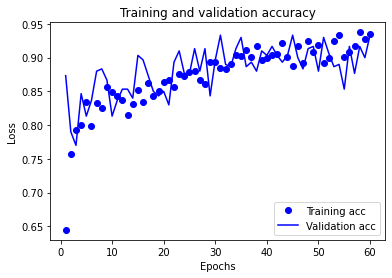

In [ ]:
import matplotlib.pyplot as plt

history = np.load(PATH_SAVE + '2021.07.03.dogfacenet.59.npy')
loss = history[0]
val_loss = history[1]
acc = history[2]
val_acc = history[3]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


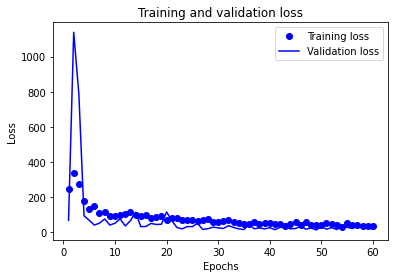

In [ ]:
plt.clf()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()